In [1]:
####  I make use of 2 magics in here. Everything should work regardless. -Delilah

In [2]:
#%%
"""                  Chem 210A/B  C.W. McCurdy
 Finite Element Method - Discrete Variable Representation (FEM-DVR) 
 for 1D Schroedinger equation using Gauss-Lobatto quadrature in each finite element
 Uses class DVRHelper() to construct FEM-DVR points, weights and Kinetic Energy


"""
#%%
# preliminaries to invoke SciPy linear algebra functions 
from scipy import linalg as LA
# and NumPy which is used to define pi, sqrt, array, .transpose etc. as 
import numpy as np
import matplotlib.pyplot as plt  # import matplotlib pyplot functions
from matplotlib import animation  # for animation from same class library
import os  # functions to manipulate files and directories
from DVR.DVRHelper import DVRHelper  # contains Barbalinardo/McCurdy FEM-DVR and Crank Nicolson functions
import time as timeclock  # for timing parts of the calculation during debugging
from datascience import *
%matplotlib inline
#================================================================================
#  This McCurdy version puts all the plots and data files in a subdirectory of the 
#  working directory   to keep them together, and make them easier to find
#      **** Make Directory for Plots if it's not there already ****
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Plot_Output = path+'/Plot_Output'
if os.path.exists(Plot_Output):
    print("Directory for wave function plots already exists",Plot_Output)
else:
    print("Attempting to create directory for wave function plots ",Plot_Output)
    try:  
        os.mkdir(Plot_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Plot_Output)
    else:  
        print ("Successfully created the directory %s " % Plot_Output)
#%%
#
from datascience import *

The current working directory is C:\Users\Delilahs PC\Downloads
Directory for wave function plots already exists C:\Users\Delilahs PC\Downloads/Plot_Output


In [3]:
#=====================================FEM_DVR===================================
#
#  Set up the FEM DVR grid given only the Finite Element boundaries and order
#  of Gauss Lobatto quadrature,  and compute the Kinetic Energy matrix for 
#  this FEM DVR for Mass = mass set in call (atomic units).
#
Daltons_to_eMass = 1822.89
bohr_to_Angstrom = 0.529177
Hartree_to_wavenumber =  8065.54*27.211
atu_to_fs = 24.18884 /1000.0
#
MassH = 1.007825032   # H atom, not average atomic mass for standard abundance of hydrogen 
MassD = 2.014101778   # D atom
MassO = 15.994914619  # oxygen 16 
# Reduced mass for OH+
mu = Daltons_to_eMass*MassH*MassO/(MassH + MassO)
n_order = 30  # <--- 30th order or higher necessary for long propagations  with 1 bohr finite elements.
FEM_boundaries = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.,12.,14.,16.,18.,20.,22.,24.,26.] # <- extend to larger R for short time treatment of  dissociation
print("Mass = ",mu)
dvr = DVRHelper(n_order, FEM_boundaries,Mass=mu)
print("\nFEM-DVR basis of ", dvr.nbas, " functions")
#%%
# =============== Other parameters for these calculations ===============
# 
#   
tfinal =   15/atu_to_fs  # <--- Time propagation from t = 0 to tfinal (in atomic time units)
                         # Here needs to be long enough to reach times where
                         # norm of component of packet on Vpot2 is linear in t
#
time_step = 0.01  # <--- time step for Crank-Nicolson propagator in atomic time units 
                  # long propagations and masses heavier than deuterium require smaller steps
                  # and denser DVR grids.
# 
N_plot_points = 500  # <--- number of points for all wave function plots
                     # Every frame of animation must have same number
                     # Making the plots takes longer than the propagation intervals
# ========================================================================
#
# Functions to define potentials and coupling for 2 electronic states 
#     at x and t (if potential is time-dependent)
#     Also coupling potential appears here, as do a zero potential
#     and one that is the dissociative potential in Vpot2 shifted 
#     up in energy to get it out of the way when we want to calculate
#     eigenfunctions in the Vpot1 (bound) well.
#
def Vpot1(x,time):
    #
    #   Morse potential = d*( 1  -  exp(-a (r-re)) )**2
    #   This is a time-independent potential
    #   Set the Morse parameters for the singlet Pi  state of OH+  
    #  ^1Pi: 0.0061972 + 0.0673785*(1.-exp(-1.05*(r-2.39709)))**2
    #   with the entire curve shifted to put the crossing near 
    #   the n = 0 state of this curve
          a = 1.05 
          re = 2.339709
          d =   0.0673785
          Eshift = 0.05   # shift to get crossing with Vpot2 near n = 0 level of this potential
    #  potential
          y = np.exp(-a*(x-re))
          term = (1.0 - y)**2
          pot  = d*term + Eshift
          return pot
break_val  =   0.0673785 +  0.05  #  dissociation limit of Vpot1, the bound potential well

def Vpot2(x,time):
    #
    #   Morse potential = d*( 1  -  exp(-a (r-re)) )**2
    #   This is a time-independent potential
    #   The Morse parameters are for quintet Sigma- state of OH+ 
    #   with re shifted inward from re = 5.0 to place the crossing near
    #   n = 0 vibrational level of Vpot1
    #
          a = 0.74
          re = 4.5
          d =   0.00567
    #  potential
          y = np.exp(-a*(x-re))
          term = (1.0 - y)**2
          pot  = d*term -d
          return pot

def Vpot2_shifted(x,time):
    #
    #   Morse potential = d*( 1  -  exp(-a (r-re)) )**2
    #   This is a time-independent potential
    #   The Morse parameters are for quintet Sigma- state of OH+ 
    #   with re shifted inward from re = 5.0 to place the crossing near
    #   n = 0 vibrational level of Vpot1
    #
          a = 0.74
          re = 4.5
          d =   0.00567
    #  potential
          y = np.exp(-a*(x-re))
          term = (1.0 - y)**2
          pot  = d*term -d
    # shift this potential out of the way to reveal eigenfunctions of Vpot1 only
          E_shift_out_of_way =1.0 
          pot = pot + E_shift_out_of_way
          return pot

def Vcoupling(x,time):
    #
    # Gaussian at the crossing of the Morse potentials in the diabatic basis
    #
    a = 5. 
    c = 0.0015  
    # V_coupling = c*np.exp(-a*(x-2.56)**2)
    V_coupling = c
    return V_coupling

def Vzero(x,time):
    # use this to replace the other potentials in call to dvr.Hamiltonian()
    # with V(R) = 0 when we want to compute diabatic state vibrational eigenvalues 
    # or eigenvalues for separate diabatic states
    Vcoupzero = 0.0
    return Vcoupzero
#%%

Mass =  1728.2581945944282

From FEM_DVR_build: building grid and KE with Gauss Lobatto quadrature of order  30
element  1  xmin =  0.0  xmax =  1.0
element  2  xmin =  1.0  xmax =  2.0
element  3  xmin =  2.0  xmax =  3.0
element  4  xmin =  3.0  xmax =  4.0
element  5  xmin =  4.0  xmax =  5.0
element  6  xmin =  5.0  xmax =  6.0
element  7  xmin =  6.0  xmax =  7.0
element  8  xmin =  7.0  xmax =  8.0
element  9  xmin =  8.0  xmax =  10.0
element  10  xmin =  10.0  xmax =  12.0
element  11  xmin =  12.0  xmax =  14.0
element  12  xmin =  14.0  xmax =  16.0
element  13  xmin =  16.0  xmax =  18.0
element  14  xmin =  18.0  xmax =  20.0
element  15  xmin =  20.0  xmax =  22.0
element  16  xmin =  22.0  xmax =  24.0
element  17  xmin =  24.0  xmax =  26.0

FEM-DVR basis of  492  functions



 Plot potential 

 Running from terminal, close figure window to proceed and make .pdf file of figure


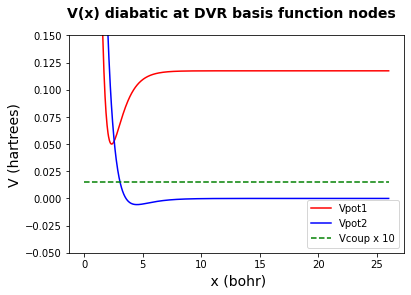


 Completed construction of diabatic Hamiltonian Vpot1 --  with Vpot2 shifted up out of the way


In [4]:
# first plot

#  Plot all three potentials on the DVR grid points on which the wavefunction is defined
print("\n Plot potential ")
time = 0.0  # potentials are time independent, but call of DVR routines uses V(x,t)
x_Plot = []
pot1_Plot = []
pot2_Plot = []
coup_Plot = []
for j in range(0,dvr.nbas):
    x_Plot.append(dvr.x_pts[j+1])
    pot1_Plot.append(Vpot1(dvr.x_pts[j+1],time))
    pot2_Plot.append(Vpot2(dvr.x_pts[j+1],time))
    coup_Plot.append(10.0*Vcoupling(dvr.x_pts[j+1],time))
plt.suptitle('V(x) diabatic at DVR basis function nodes', fontsize=14, fontweight='bold')
string="Vpot1"
#plt.plot(x_Plot,pot1_Plot,'ro',label=string) # plot points only 
plt.plot(x_Plot,pot1_Plot,'-r',label=string)
string="Vpot2"
plt.plot(x_Plot,pot2_Plot,'-b',label=string)
string="Vcoup x 10"
plt.plot(x_Plot,coup_Plot,color='green',linestyle='dashed',label=string)
plt.legend(loc="best")
plt.xlabel(" x (bohr)", fontsize=14)
plt.ylabel("V (hartrees)", fontsize=14)
print("\n Running from terminal, close figure window to proceed and make .pdf file of figure")
#   Insert limits if necessary
#xmax = float(rmax)  # CWM: need to use float() to get plt.xlim to work to set x limits
#plt.xlim([0,xmax])
plt.ylim([-.05,0.15])
#number_string = str(a)
plt.savefig('Plot_Output/' + 'Plot_two_state_potentials' + '.pdf', transparent=False)
plt.show()
#==================================================================================
# =============Build Hamiltonian without coupling to pick an initial state=========
#           Pass names of the three potential functions explicitly here
#           Note that to get the bound states of Vpot1 to appear first in the 
#           list of eigenvalues, a shifted version of Vpot2 is used to move its
#           eigenvalues out of the way to higher energies so the lower eigenvalues 
#           belong to just Vpot1 when we are doing that part of the calculation.
time = 0.0  # The Hamiltonian iss time independent, this is a dummy time.
H_mat = dvr.Hamiltonian_Two_States(Vpot1,Vpot2_shifted,Vzero, time)
print("\n Completed construction of diabatic Hamiltonian Vpot1 --  with Vpot2 shifted up out of the way")
#====================================================================================
#

Calculating  40  eigenvectors for plotting diabatic eigenfunctions and picking initial vibrational state
   n             Eigenvalue ( hartrees ) on initial diabatic state (Vpot1) 
0                        0.05455612300339966
1                        0.0631899248734693
2                        0.07118580122786339
3                        0.07854375206656791
4                        0.08526377738962468
5                        0.09134587719699205
6                        0.09679005148869763
7                        0.10159630026472768
8                        0.10576462352509611
9                        0.10929502126977494
10                        0.1121874934988061
11                        0.11444204021214777
12                        0.11605866140982776
13                        0.1170373570918182
14                        0.11737960118450178
15                        0.11739929267837718
16                        0.11743682499912059
17                        0.11749080445863197
18  

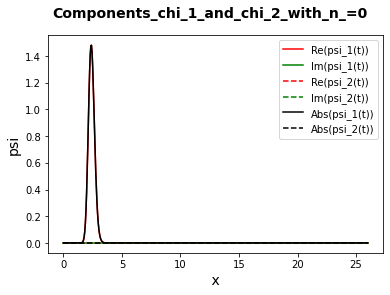


 Completed construction of diabatic two-state Hamiltonian 
Norm check =  1.0000000000000004


In [5]:
# second plot

# Find eigenvalues and eigenvectors of the Hamiltonian for Vpot1 (actually
#  the Hamiltonian for Vpot1 and Vpot2 with the coupling set to zero and Vpot2 shifted up 
#  out of the way.
#
#==========Initial state selection and definition  =======================================
#
# Extract the n_Initial_State'th eigenfunction of the diabatic Hamiltonians for plotting 
# both components and identifying a diabatic vibrational eigenstate to use as the initial
# state.  Eigenvalues come back from LA.eigh ordered lowest to highest.   
#
np1 = 40 # <--- number of diabatic eigenfunctions of Vpot1 to calculate (H_mat has Vcoupling = 0 at this point) 
number_of_eigenvectors_initial = np1
print("Calculating ",np1," eigenvectors for plotting diabatic eigenfunctions and picking initial vibrational state")
#EigenVals = []
EigenVals_initial_diabatic, EigenVecs  = LA.eigh(H_mat,eigvals=(0,number_of_eigenvectors_initial))
print("   n             Eigenvalue ( hartrees ) on initial diabatic state (Vpot1) ")
for i in range(0,np1):
  print(i,"                      ",EigenVals_initial_diabatic[i])
wfcn_initial_Plot = []
#
#
#
#    this is where I delected what no = n=0,1,2
#
# ========================================================================================================
n_Initial_State = 0  # HERE pick one of the diabatic vibrational bound states to plot and use as initial state below
            # indexing starts with 0 and they are ordered by energy in EigenVals_initial_diabatic[i]
# ========================================================================================================
#
for j in range(0,2*dvr.nbas):
    wfcn_initial_Plot.append(EigenVecs[j,n_Initial_State])
#
# normalize 2 component wave function from diagonalization
# so that it has the right overall normalization
#
norm_squared = 0.
for j in range(0,2*dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcn_initial_Plot[j])**2    
wfcn_initial_Plot = wfcn_initial_Plot/np.sqrt(norm_squared)
norm_squared = 0.0
# check that norm and print out which state is chosen as initial state for propagation
for j in range(0,2*dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcn_initial_Plot[j])**2    
print("Norm of wave function ",n_Initial_State,"  being plotted is ", np.sqrt(norm_squared))
# now extract the two components
wfcn_initial_Plot1=[]
wfcn_initial_Plot2=[]
for j in range(0,dvr.nbas):
    wfcn_initial_Plot1.append(wfcn_initial_Plot[j,])  #CORRECT , that didn't matter?
    wfcn_initial_Plot2.append(wfcn_initial_Plot[j+dvr.nbas])
x_Plot_array, Psi1_plot_array, Psi2_plot_array = dvr.Plot_Psi_Two_States(wfcn_initial_Plot1, wfcn_initial_Plot2,plot_title_string="Components_chi_1_and_chi_2_with_n_="+str(n_Initial_State),N_plot_points=N_plot_points,make_plot=True)
#
#====================================================================================
# Now find the eigenvalues and eigenvectors of the actual complete  diabatic Hamiltonian with Vpot1 and Vpot2
# but Vcoupling = 0
#
time = 0.0
H_mat = dvr.Hamiltonian_Two_States(Vpot1,Vpot2,Vzero, time)
print("\n Completed construction of diabatic two-state Hamiltonian ")
number_of_eigenvectors = 200
EigenVals_complete_diabatic, EigenVecs_complete_diabatic  = LA.eigh(H_mat,eigvals=(0,number_of_eigenvectors))
#
# normalize 2 component wave functions from diagonalization
# so that they have  the right overall normalization <chi1|chi1> + <chi2|chi2> = 1
#
for i_vec in range(0,number_of_eigenvectors):
    norm_squared = 0.
    for j in range(0,2*dvr.nbas):
        norm_squared = norm_squared + np.abs(EigenVecs_complete_diabatic[j,i_vec])**2    
    EigenVecs_complete_diabatic[i_vec] = EigenVecs_complete_diabatic[i_vec]/np.sqrt(norm_squared)
# check one
norm_squared = 0.
for j in range(0,2*dvr.nbas) :
    norm_squared = norm_squared + np.abs(EigenVecs_complete_diabatic[j,88])**2
print("Norm check = ",norm_squared)
#%%
#
#=====================================================================================  
#

In [6]:
#     Propagation Section
#
# =============Build complete Hamiltonian with couplings. It is time-independent  ===
#     Pass name of potential functions explicitly here
time = 0.0
H_mat = dvr.Hamiltonian_Two_States(Vpot1,Vpot2,Vcoupling, time)
print("\n Completed construction of complete two-state Hamiltonian with coupling between diabatic states")
#====================================================================================
#
# Find ALL the eigenvalues of the complete two-state Hamiltonian so we can compare with known bound state energies
# or make a plot of the spectrum -- (time-independent Hamiltonian example here).
#
EigenVals = LA.eigvalsh(H_mat)
# Print the lowest few eigenvalues as a check, and help pick an initial state in one diabatic well 
print("\nEigenvalues of the coupled adiabatic Hamiltonians and uncoupled diabatic Hamiltonians")
print("n     E_adiabatic                E_diabatic")
for i in range(0,number_of_eigenvectors):
    print(i,"  ",EigenVals[i], "    ",EigenVals_complete_diabatic[i])
#%%


 Completed construction of complete two-state Hamiltonian with coupling between diabatic states

Eigenvalues of the coupled adiabatic Hamiltonians and uncoupled diabatic Hamiltonians
n     E_adiabatic                E_diabatic
0    -0.004782211394354398      -0.004761834209303605
1    -0.003203294647402183      -0.003183140731573432
2    -0.0019412255290964684      -0.0019212980587114056
3    -0.0009960078652782663      -0.0009763061907448933
4    -0.0003676454706207083      -0.0003481651276602109
5    -5.613921418019253e-05      -3.687285564563355e-05
6    -5.2309713829878235e-06      1.394785167039879e-05
7    3.202564871939754e-05      5.122167037626329e-05
8    8.800228734600161e-05      0.00010721204545168146
9    0.0001606192305534762      0.00017984112344060933
10    0.00024869210094173133      0.0002679254586706611
11    0.0003514153121418097      0.00037065981331023786
12    0.000468191603226086      0.00048744707860137406
13    0.0005985549366444217      0.000617821300739778

In [7]:
#
#  Fermi Golden Rule logic can go here, but you have to know (to set by hand
#      for each case) or insert logic to find or calculate:
#  (1) Which state of the bound diabatic curve (Vpot1) is the initial state
#      and was chosen using n_Initial_State above.  You need to find its index in the full list
#      EigenVals_complete_diabatic[], which you can do manually by running the whole 
#      code and examining the complete list of Eigenvals_complete_diabatic[].  
#      That index is specified as "n_initial_state_in_list" in the template below. 
#  (2) Which state in the complete list of diabatic eigenstates is the state of Vpot2
#      is just below or just above  the initial state in (1) in energy.  Either one
#      can be used for the Fermi Golden Rule matrix element.  They are identified
#      from n_initial_state_in_list, specified below, that you have to identify
#      
#  The states in EigenVecs_complete_diabatic[j,i_vector] are indexed by columns
#   (second index numbers the vector) and are normalized already.  They didn't come 
#   out of LA.eigh normalized.
#
#  Then you build the Fermi Golden Rule matrix element of V_coupling(x,t)
#  REMEMBER for this calculation and the calculation of <r> the indexing
#    of the array of points in x is dvr.x_pts[j+1] with j = 0 ... dvr.nbas -1
#    The endpoints of that array (dvr.x_pts[0] and dvr.x_pts[dvr.nbas]) are the
#    endpoints of the FEM-DVR grid where the wave function is constrained to be zero.
#
#  (3) Calculate the density of states by finite difference using the eigenvalues 
#      in EigenVals_complete_diabatic just below and above the initial state energy
#      Those are discretized dissociative continuum states on the potential Vpot2 
#      and plotting the ones you choose here just above or below the initial state
#      energy using the DVRHelper plotting function is instructive and helps understand
#      what the Fermi Golden Rule matrix element is
#
#    
n_initial_state_in_list = 102
n_cont_Vpot2 = n_initial_state_in_list - 1
n_2nd_cont_Vpot2 = n_initial_state_in_list + 1
print("\n  **** Fermi Golden Rule calculation of predissociation rate: Starting point ***")
print("  Initial state is n = ",n_Initial_State," in Vpot1 with energy ",
                                EigenVals_initial_diabatic[n_Initial_State])
print("  That eigenvector appears as number ", n_initial_state_in_list,
                                        " in complete diabatic eigenvalues with E =",
                                      EigenVals_complete_diabatic[n_initial_state_in_list])
print("     and those two eigenvalues had better be the same!")
print("  For density of states calculation continuum states are numbers ",
                                       n_cont_Vpot2," and ",n_2nd_cont_Vpot2)
print("  Fermi Golden Rule matrix element V12 is between ", 
                                n_initial_state_in_list," and ",n_cont_Vpot2)
# Now calculate the matrix element V12
sum_Fermi = 0.0
for j in range(0, dvr.nbas):
    sum_Fermi = sum_Fermi + wfcn_initial_Plot[j]* \
             EigenVecs_complete_diabatic[j + dvr.nbas,n_cont_Vpot2]* \
             Vcoupling(dvr.x_pts[j+1],0.0)
V12 = sum_Fermi
print("    Fermi Golden Rule matrix element V12 = ", V12,"  ")
#
# now you have to calculate the density of states and assemble the Fermi Golden Rule
# expression for the rate
# When you are debugging this part of your code you can put an exit() or just stop here, because
# you don't need the time propagation below to evaluage Fermi's Golden Rule
#
#exit()
#%%
#




  **** Fermi Golden Rule calculation of predissociation rate: Starting point ***
  Initial state is n =  0  in Vpot1 with energy  0.05455612300339966
  That eigenvector appears as number  102  in complete diabatic eigenvalues with E = 0.05455612300341032
     and those two eigenvalues had better be the same!
  For density of states calculation continuum states are numbers  101  and  103
  Fermi Golden Rule matrix element V12 is between  102  and  101
    Fermi Golden Rule matrix element V12 =  (-0.00016017318530886163+0j)   


In [8]:
#================# Initialize wave function at t = 0 ================================
#
#  Bound state of one diabat chosen as initial state
#
Cinitial = np.zeros(2*dvr.nbas,dtype=complex)
for i in range(0,2*dvr.nbas):
    Cinitial[i] =  wfcn_initial_Plot[i] + 0.0*1j # this loop was necessary to make Cinitial an array of complex numbers
wfcnInitialPlot1 = np.zeros(dvr.nbas,dtype=complex)
wfcnInitialPlot2 = np.zeros(dvr.nbas,dtype=complex)
norm_1 = 0.0
norm_2 = 0.0
for j in range(0,dvr.nbas):
    wfcnInitialPlot1[j] = Cinitial[j]
    wfcnInitialPlot2[j] = Cinitial[j+dvr.nbas]
    norm_1 = norm_1 + np.abs(wfcnInitialPlot1[j])**2
    norm_2 = norm_2 + np.abs(wfcnInitialPlot2[j])**2
#
#%%
# Logic for initial calculation of <r> at t = 0 can go here
# or you can just set the values of <r> at t = 0 to zero in your arrays
# That won't mess up your plots significantly.
#  If you compute <r> at t=0, the norm of initial component on Vpot1 is one, and on Vpot2 is 
#  zero. So no need to worry about the norms -- at t = 0
#%%
#


 Plot initial wave function at t =  0.0


<IPython.core.display.Javascript object>


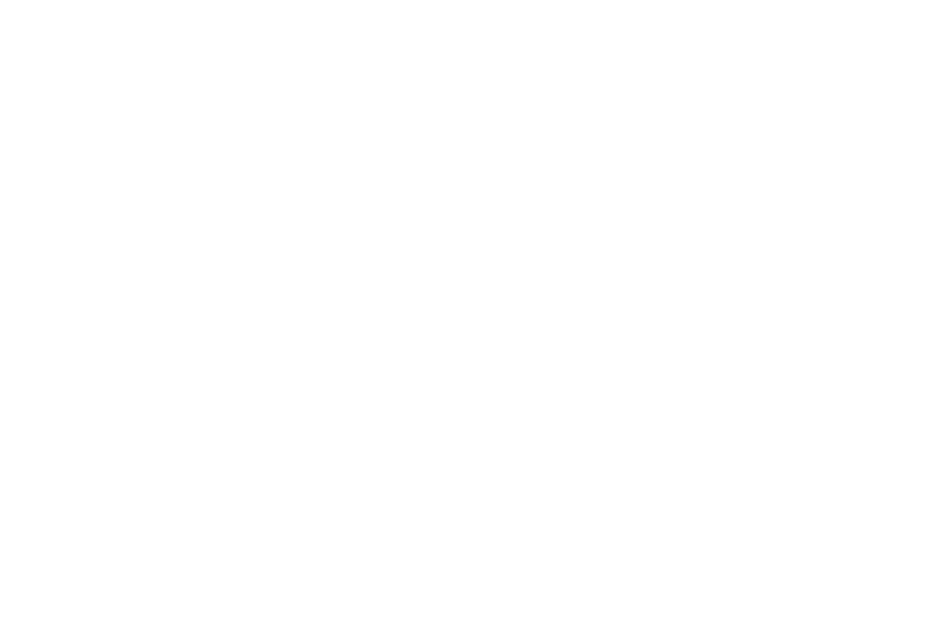


 Running from terminal, close figure window to proceed and make .pdf file of figure

Overall propagation will be from  0.0  to  620.1206837533342  =  15.000099219309401 fs in  51  intervals

Norm of starting  wave function 0.9999999999999999  norm on state 1  0.9999999999999999  norm on state 2  0.0
Start Crank Nicolson propagation from  0.0  to  12.159229093202631  atu
                              in steps of  0.010007595961483647  with  1215  steps
End Crank-Nicolson propagation at time =  12.159229093202631
Time for  1215  Crank-Nicolson steps was  1.1936790943145752  secs.
Norm of final  wave function 0.99999999999988  norm on state 1  0.9996733960404737  norm on state 2  0.00032660395940631304
Plot function propagated to t =  12.159229093202631  atomic time units =  0.2941195925354784  fs

Norm of starting  wave function 0.99999999999988  norm on state 1  0.9996733960404737  norm on state 2  0.00032660395940631304
Start Crank Nicolson propagation from  12.159229093202631  to  24

<IPython.core.display.Javascript object>


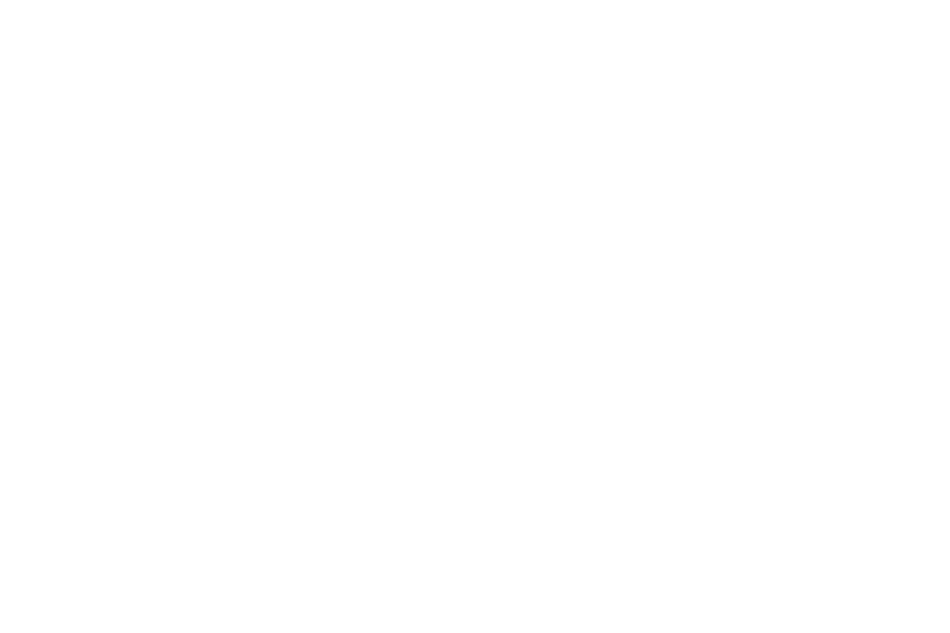


 Running from terminal, close figure window to proceed and make .pdf file of figure
Final frame at tfinal =  620.1206837533342 atomic time units  is showing -- ready to prepare animation 

 **** close the plot window to proceed ****


<IPython.core.display.Javascript object>


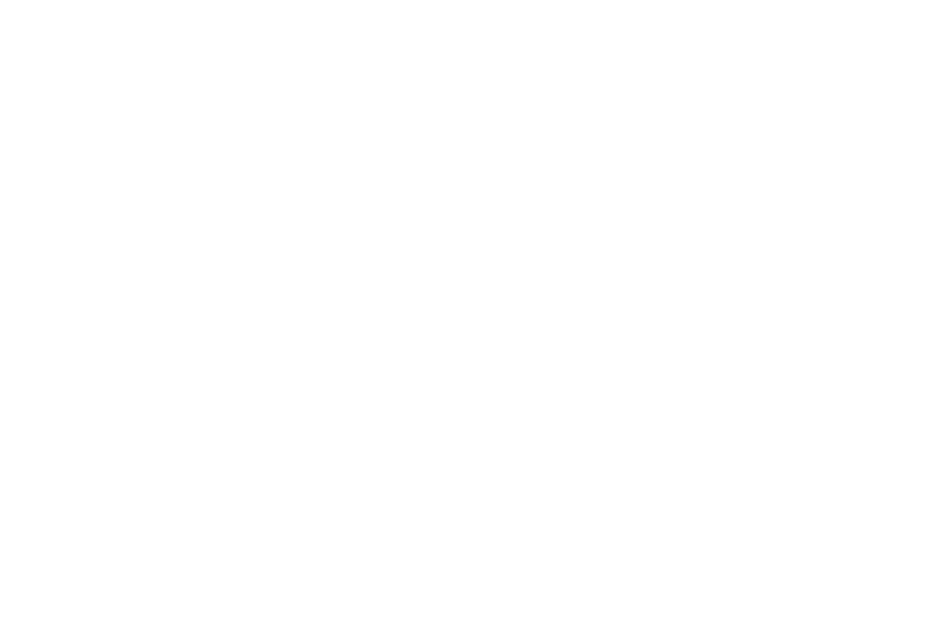

done


In [9]:
# third plot
%matplotlib notebook
# plot initial wave packet
#
tinitial = 0.0
print("\n Plot initial wave function at t = ",tinitial)
number_string = str(0.0)
title = 'Wavefunction_at_t_='+number_string
x_Plot_array, Psi1_plot_array, Psi2_plot_array = dvr.Plot_Psi_Two_States(wfcnInitialPlot1,wfcnInitialPlot2, plot_title_string=title,N_plot_points=N_plot_points,make_plot=True)
#
#  *** When working on the Fermi Golden Rule logic there is no need to do the propagation 
#                     so you can put an exit here while you are doing that part  ***
#exit()
#
# initialize arrays for storing the information for all the frames in the animation of 
# the propagation of the wave function
#   *** For Exam initialization of arrays for expectation value of r
#   can go here.  You need to initialize an array for both expectation 
#   values, maybe calling  them:  expectation_value_of_r_on_Vpot1, and expectation_value_of_r_on_Vpot2
#
times_array = []
norm_1_array = []  
norm_2_array = []  
x_Plot_time_array = []
Psi1_plot_time_array = []
Psi2_plot_time_array = []
times_array.append(tinitial)
x_Plot_time_array.append(x_Plot_array)
Psi1_plot_time_array.append(Psi1_plot_array)
Psi2_plot_time_array.append(Psi2_plot_array)
norm_1_array.append(norm_1)  
norm_2_array.append(norm_2)  
#
#=====================Propagation from t = tinitial to tfinal ============================
# Specify number of intervals for plotting.
# Time step and final time specified above.
#
n_intervals = 51 
print("\nOverall propagation will be from ",tinitial," to ",tfinal," = ",tfinal*24.189/1000.0,"fs in ",n_intervals," intervals")
#
#  Loop over n_intervals intervals that make up t = 0 to tfinal
#
t_interval = (tfinal-tinitial)/n_intervals
#
for i_time_interval in range(0,n_intervals):
    t_start = tinitial + i_time_interval*t_interval
    t_finish = tinitial + (i_time_interval+1)*t_interval
    N_time_steps = int(t_interval/time_step)   
    Delta_t = t_interval/float(N_time_steps)
    # 
    # Check norm of initial wavefunction
    # and compute norms of the two components separately
    #
    norm_initial = 0.
    norm_1 = 0.  
    for j in range(0,2*dvr.nbas):
        norm_initial = norm_initial + np.abs(Cinitial[j])**2    
        if(j < dvr.nbas):  
            norm_1 = norm_1 + np.abs(Cinitial[j])**2  
    norm_2 = norm_initial - norm_1  
    print("\nNorm of starting  wave function", norm_initial," norm on state 1 ",norm_1," norm on state 2 ",norm_2)
    #
    #  use the propagator from DVRHelper class library
    #
    clock_start = timeclock.time()
    Ctfinal = dvr.Crank_Nicolson_Two_States(t_start, t_finish, N_time_steps, Cinitial, Vpot1, Vpot2, Vcoupling, Is_H_time_dependent=False)
    clock_finish = timeclock.time()
    print("Time for ",N_time_steps," Crank-Nicolson steps was ",clock_finish-clock_start," secs.")
    #
    # Calculate  norms of initial  wavefunctions
    # Note indexing for both first and second components is contained in Ctfinal[]
    # That's important:  Ctfinal[0] through Ctfinal[dvr.nbas-1] is the first component (i.e. on state 1)
    #                    Ctfinal[dvr.nbas] through Ctfinal[2*dvr.nbas - 1] is the second component (on state 2)
    #
    norm_final = 0
    norm_1 = 0.  
    for j in range(0,2*dvr.nbas):
        # total norm for state 1 + state 2 components:
        norm_final = norm_final + np.abs(Ctfinal[j])**2
        # norm for state 1    
        if(j < dvr.nbas):  
            norm_1 = norm_1 + np.abs(Ctfinal[j])**2  
    norm_2 = norm_final - norm_1  
    print("Norm of final  wave function", norm_final," norm on state 1 ",norm_1," norm on state 2 ",norm_2)
    #  place the norms in arrays initialized above for writing out to a plot file
    norm_1_array.append(norm_1)  
    norm_2_array.append(norm_2)  
    #
    #%%
    #  *** For Exam logic for computing average value of r for each of the two components
    #  can go here.   NOTE: the two components are not normalized separately to one
    #  because norm_1 + norm_2 = 1.   So these two expectation values are, for the
    #  first component for example, <r> = <chi_1|r|chi_1>/norm_1.  The same for the 
    #  second component on the dissociative state.
    #  ALSO NOTE:  The values of r are in dvr.x_pts[j] for j in range(0,dvr.nbas) so when you
    #  adapt the logic above for computing norms, you need to pair np.abs(Ctfinal[j]) for the
    #  two states with the right values of r in the integrand -- something like
    #    rave_1 = rave_1  + dvr.x_pts[j+1]* np.abs(Ctfinal[j])**2    
    #    rave_2 = rave_2  + dvr.x_pts[j+1]* np.abs(Ctfinal[j+dvr.nbas])
    #  inside the right for loop.
    #%%
    #
    # Plot of packet at end of each interval using Plot_Psi from DVR()
    #  "False" returns the values but doesn't make a plot, so the values
    #  can be used in the animation.
    #
    print("Plot function propagated to t = ",t_finish," atomic time units = ",t_finish*24.189/1000.0," fs")
    number_string = str(t_finish)
    title = 'Wavefunction_at_t='+number_string
    wfcn_at_t_Plot1 = np.zeros(dvr.nbas,dtype=complex)
    wfcn_at_t_Plot2 = np.zeros(dvr.nbas,dtype=complex)
    for j in range(0,dvr.nbas):
        wfcn_at_t_Plot1[j] = Ctfinal[j]
        wfcn_at_t_Plot2[j] = Ctfinal[j+dvr.nbas]
    # plot using the Plot_Psi_Two_States function in DVRHelper, returns two components of wave function separately
    x_Plot_array, Psi1_plot_array, Psi2_plot_array = dvr.Plot_Psi_Two_States(wfcn_at_t_Plot1,wfcn_at_t_Plot2, plot_title_string=title,N_plot_points=N_plot_points,make_plot=False)
    times_array.append(t_finish)
    # you might want to append the values of the average values of r to their arrays here
    x_Plot_time_array.append(x_Plot_array)
    Psi1_plot_time_array.append(Psi1_plot_array)
    Psi2_plot_time_array.append(Psi2_plot_array)
#
#   reset initial packet as final packet for this interval
#
    for i in range(0,2*dvr.nbas):
        Cinitial[i] = Ctfinal[i]
#

# animation

# ============ End of Crank Nicolson propagation of wave packet ====================
#
x_Plot_array, Psi1_plot_array, Psi2_plot_array = dvr.Plot_Psi_Two_States(wfcn_at_t_Plot1,wfcn_at_t_Plot2, plot_title_string=title,N_plot_points=N_plot_points,make_plot=True)
print("Final frame at tfinal = ",tfinal,"atomic time units  is showing -- ready to prepare animation ")
print("\n **** close the plot window to proceed ****")
#
# Print a file with norms of the components of the wave function as a function of time
#
#%%
#   For Exam: Here you can add the printing of <r>  once you have saved it after each interval
#   Also, maybe you can take the numerical derivative of the values in norm_2_array[k]
#    using that array and times_array[] that has the times at the end of each interval.
#    When that derivative becomes approximately constant, it gives the rate of population
#    of the Vpot2 dissociative state
#%%    
#
norms_file = open('./Plot_Output/Wavepacket_norms.dat','w')  #<-- your data for plots of populations, <r> etc
for k in range(0,n_intervals):
    norms_file.write("%12.8f %12.8f %12.8f \n" \
        % (times_array[k],norm_1_array[k],norm_2_array[k]))
# 
norms_file.close()



#==============================================================================
# # initialization function: plot the background of each frame
#==============================================================================
def init():
    line.set_data([], [])
    time_text.set_text('')
    ax.set_xlabel(" x (bohr) ",fontsize=16,fontweight='bold')
    ax.set_ylabel(" |Psi_1(t)| and |Psi_2(t)| ",fontsize=16,fontweight='bold') 
    fig.suptitle('Nonadiabatic Wave Packet', fontsize=16, fontweight='bold')
    ax.plot([x_Plot[0],x_Plot[len(x_Plot)-1]],[0,0],'k')  # put in a line at the value Phi = 0
    return line, time_text

nframes =  n_intervals 

def animate(i):
#==============================================================================
# 
#  commands to specify changing elements of the animation 
#  We precomputed all the lines at all the times so that this
#  wouldn't recompute everything at each frame, which is very slow...
# 
#==============================================================================
    time_string = str(times_array[i]*24.189/1000.0) # string for a plot label
#    re_array = np.real(Psi1_plot_time_array[i])
#    im_array = np.imag(Psi1_plot_time_array[i])
    abs_array1 = np.abs(Psi1_plot_time_array[i])
    abs_array2 = np.abs(Psi2_plot_time_array[i])
    line1.set_data(x_Plot_array,abs_array1)
    line2.set_data(x_Plot_array,abs_array2)
#    line3.set_data(x_Plot_array,abs_array)
    time_text.set_text('time = '+time_string+' fs')
#    return (line1,line2,line3,time_text) 
    return (line1,line2,time_text) 

#==============================================================================
#  Now plot the animation 
#==============================================================================
# reinitialize the figure for the next plot which is the animation
fig = plt.figure()
ymax = 2.0
xmin = x_Plot[0]
xmax = x_Plot[len(x_Plot)-1]
ax = fig.add_subplot(111, autoscale_on=False, xlim=(xmin,xmax), ylim=(0, +ymax) )
line, = ax.plot([], [], '-r',lw=2)
line1, = ax.plot([], [], '-r',lw=2)
line2, = ax.plot([], [], '-b',lw=2)
#line3, = ax.plot([], [], 'k',lw=2)
# define the object that will be the time printed on each frame 
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

#==============================================================================
# call the animator.  blit=True means only re-draw the parts that have changed.
#==============================================================================
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nframes+1, interval=200, blit=True,repeat=True)
#==============================================================================
#  show the animation, saving it first as a .mp4 file
#==============================================================================
anim.save('Plot_Output/Non_adiabatic_coupled_Morse_pots.mp4')
plt.show()
print('done')
#exit()

In [10]:
%matplotlib inline

In [11]:
#### 1 a these are the plots for the populations

In [12]:
# the array for the norm value for n=0 chi1
normarrayn0chi1 = np.array([0.9999999999999999,
 0.9996733960404737,
 0.9987597866867263,
 0.9974179888353725,
 0.9958184871803307,
 0.9940869409033267,
 0.992294608681804,
 0.9904751642008255,
 0.9886434764448802,
 0.9868068616049718,
 0.9849696498617918,
 0.9831343044507532,
 0.981301474035042,
 0.979470243312442,
 0.9776390397585989,
 0.9758069605832635,
 0.9739747348596828,
 0.9721445271449954,
 0.9703185764673047,
 0.9684977402236199,
 0.966681258756011,
 0.9648679394969033,
 0.9630574928854294,
 0.9612506319513198,
 0.9594480347757592,
 0.9576495786990262,
 0.9558547311378081,
 0.9540633797606299,
 0.9522759099845663,
 0.9504925472068131,
 0.9487130192541582,
 0.9469369824561266,
 0.945164458108951,
 0.9433956025051504,
 0.9416302448890164,
 0.9398679478653814,
 0.9381084356157713,
 0.9363516530318381,
 0.9345973839519199,
 0.9328450942966794,
 0.9310942512570455,
 0.9293445580589008,
 0.9275957180447301,
 0.9258471646547399,
 0.9240982428120353,
 0.9223485440211752,
 0.9205978467584319,
 0.9188458129720064,
 0.9170920162328018,
 0.9153362975983378,
 0.9135788764751992,
 0.9118200701490186])

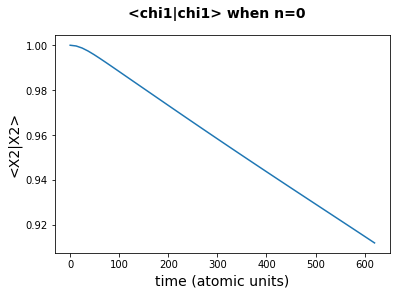

In [13]:
#### <chi1|chi1> when n=0
plt.suptitle('<chi1|chi1> when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,normarrayn0chi1)

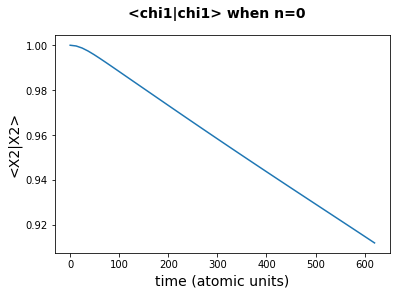

In [14]:
#### <chi1|chi1> when n=0
plt.suptitle('<chi1|chi1> when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,normarrayn0chi1)

In [15]:
# the array for the norm value for n=0 chi2
normarrayn0chi2 = np.array([0.0,
 0.00032660395940631304,
 0.001240213312948435,
 0.002582011164090625,
 0.00418151281890311,
 0.005913059095773776,
 0.007705391317111787,
 0.009524835798023434,
 0.011356523554006404,
 0.013193138393816195,
 0.015030350136880144,
 0.016865695547766513,
 0.01869852596333188,
 0.020529756685772393,
 0.022360960239495742,
 0.024193039414707407,
 0.026025265138076237,
 0.027855472852652663,
 0.029681423530166007,
 0.03150225977365928,
 0.03331874124105105,
 0.035132060499908246,
 0.036942507111135,
 0.03874936804496387,
 0.040551965220260944,
 0.042350421296710294,
 0.0441452688576377,
 0.0459366202345447,
 0.047724090010339504,
 0.049507452787880823,
 0.05128698074032212,
 0.053063017538180435,
 0.05483554188513251,
 0.05660439748865154,
 0.058369755104527354,
 0.06013205212786776,
 0.06189156437721255,
 0.06364834696086263,
 0.06540261604049091,
 0.06715490569550253,
 0.06890574873487842,
 0.07065544193286533,
 0.07240428194680637,
 0.07415283533665151,
 0.0759017571791123,
 0.07765145596968515,
 0.0794021532321908,
 0.08115418701831778,
 0.08290798375722952,
 0.0846637023914043,
 0.08642112351426179,
 0.08817992984017964])

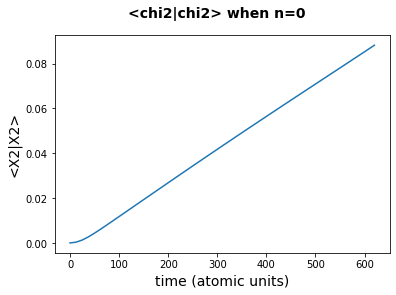

In [16]:
plt.suptitle('<chi2|chi2> when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,normarrayn0chi2)

#### <chi2|chi2> when n=0

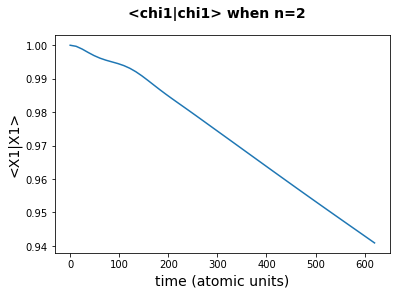

In [17]:
# the array for the norm value for n=2 chi1
normarrayn2chi1 = [1.0,
 0.9996809260850723,
 0.9988655870267216,
 0.9978577689669259,
 0.996910372164385,
 0.9961340900390886,
 0.9955271159666091,
 0.9950230768475501,
 0.9945205340255352,
 0.993910710694821,
 0.9931105016648173,
 0.9920884321992506,
 0.9908704530086455,
 0.9895237108666884,
 0.9881274582191176,
 0.9867449066490925,
 0.9854074330427022,
 0.9841153243201389,
 0.9828507871066624,
 0.9815935746539429,
 0.980330591073916,
 0.979057301939652,
 0.9777748988827674,
 0.9764875508652773,
 0.9752002123991188,
 0.9739158066207476,
 0.9726332298854624,
 0.9713489894701727,
 0.9700613865704195,
 0.9687722277734563,
 0.9674839948830608,
 0.9661967819540105,
 0.9649094042713457,
 0.963622448597142,
 0.9623381014444833,
 0.9610570965369815,
 0.9597780007702299,
 0.9585001478558138,
 0.9572253136874893,
 0.9559552234463214,
 0.9546889717981834,
 0.9534246479599646,
 0.9521624329585743,
 0.9509039958875867,
 0.9496492908462197,
 0.9483962136510126,
 0.9471436556376013,
 0.9458927246946176,
 0.9446441089371523,
 0.9433961816231027,
 0.9421471311880051,
 0.9408974602960472]
plt.suptitle('<chi1|chi1> when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X1|X1>", fontsize=14)
plt.plot(times_array,normarrayn2chi1)


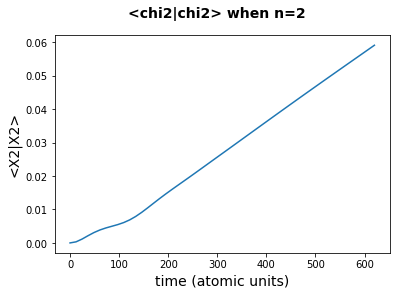

In [18]:
# the array for the norm value for n=2 chi2
normarrayn2chi2 = [0.0,
 0.00031907391488805725,
 0.001134412973117671,
 0.0021422310327702254,
 0.0030896278352551265,
 0.0038659099605113934,
 0.004472884032970081,
 0.004976923151992829,
 0.005479465973953435,
 0.00608928930459407,
 0.006889498334562871,
 0.007911567800115371,
 0.009129546990652493,
 0.010476289132537064,
 0.011872541780065693,
 0.013255093350033942,
 0.014592566956354691,
 0.01588467567889218,
 0.017149212892340615,
 0.018406425345007582,
 0.019669408924990917,
 0.020942698059227327,
 0.02222510111607101,
 0.023512449133544777,
 0.024799787599654954,
 0.02608419337796608,
 0.02736677011316102,
 0.02865101052837271,
 0.029938613428050487,
 0.031227772224918682,
 0.032516005115233226,
 0.033803218044183625,
 0.03509059572680684,
 0.036377551400953556,
 0.03766189855356439,
 0.03894290346102436,
 0.04022199922774072,
 0.04149985214207452,
 0.04277468631034498,
 0.044044776551459885,
 0.04531102819953159,
 0.04657535203769814,
 0.04783756703899822,
 0.049096004109941305,
 0.05035070915122264,
 0.051603786346385294,
 0.05285634435971698,
 0.054107275302633595,
 0.05535589106002203,
 0.05660381837399675,
 0.0578528688090123,
 0.05910253970090373]

plt.suptitle('<chi2|chi2> when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,normarrayn2chi2)

In [19]:
#### this is the code for 1b <b>
# I cannot get it to work all the way 

In [20]:
# this plot the expectation value


wfcn_initial_Plot = []
#
# ========================================================================================================
n_Initial_State = 0  # HERE pick one of the diabatic vibrational bound states to plot and use as initial state below
            # indexing starts with 0 and they are ordered by energy in EigenVals_initial_diabatic[i]
# ========================================================================================================
#
for j in range(0,2*dvr.nbas):
    wfcn_initial_Plot.append(EigenVecs[j,n_Initial_State])
#
# normalize 2 component wave function from diagonalization
# so that it has the right overall normalization
#
norm_squared = 0.
for j in range(0,2*dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcn_initial_Plot[j])**2    
wfcn_initial_Plot = wfcn_initial_Plot/np.sqrt(norm_squared)


%matplotlib notebook

Cinitial = np.zeros(2*dvr.nbas,dtype=complex)
for i in range(0,2*dvr.nbas):
    Cinitial[i] =  wfcn_initial_Plot[i] + 0.0*1j # this loop was necessary to make Cinitial an array of complex numbers
    
tinitial1 = 0.0

times_array1 = []
expectation_R_chi1 = []
expectation_R_chi2 = []

times_array1.append(tinitial1)
n_intervals1 = 51 
#
t_interval1 = (tfinal-tinitial1)/n_intervals1
#
for i in range(0,n_intervals1):
    t_start1 = tinitial1 + i*t_interval1
    t_finish1 = tinitial1 + (i+1)*t_interval1
    N_time_steps1 = int(t_interval1/time_step)   
    Delta_t1 = t_interval1/float(N_time_steps1)
    #
    clock_start1 = timeclock.time()
    Ctfinal1 = dvr.Crank_Nicolson_Two_States(t_start1, t_finish1, N_time_steps1, Cinitial, Vpot1, Vpot2, Vcoupling, Is_H_time_dependent=False)
    clock_finish1 = timeclock.time()
    
    chi1 = 0
    for j in range(0,dvr.nbas-1):
        chi1 = chi1 + (dvr.x_pts[j+1]*np.abs(Ctfinal1[j])**2)
  
    
    chi2 = 0
    for j in range(0,dvr.nbas-1)  :
        chi2 = chi2  + ( dvr.x_pts[j+1]*np.abs(Ctfinal1[j+dvr.nbas]) )


    expectation_R_chi1.append(chi1)  
    expectation_R_chi2.append(chi2) 

    times_array1.append(t_finish1)
#
    for i in range(0,2*dvr.nbas):
        Cinitial[i] = Ctfinal1[i]


Start Crank Nicolson propagation from  0.0  to  12.159229093202631  atu
                              in steps of  0.010007595961483647  with  1215  steps
End Crank-Nicolson propagation at time =  12.159229093202631
Start Crank Nicolson propagation from  12.159229093202631  to  24.318458186405262  atu
                              in steps of  0.010007595961483647  with  1215  steps
End Crank-Nicolson propagation at time =  24.318458186405262
Start Crank Nicolson propagation from  24.318458186405262  to  36.47768727960789  atu
                              in steps of  0.010007595961483646  with  1215  steps
End Crank-Nicolson propagation at time =  36.47768727960789
Start Crank Nicolson propagation from  36.47768727960789  to  48.636916372810525  atu
                              in steps of  0.010007595961483649  with  1215  steps
End Crank-Nicolson propagation at time =  48.636916372810525
Start Crank Nicolson propagation from  48.636916372810525  to  60.79614546601316  atu
        

In [21]:
# this is for when n = 0

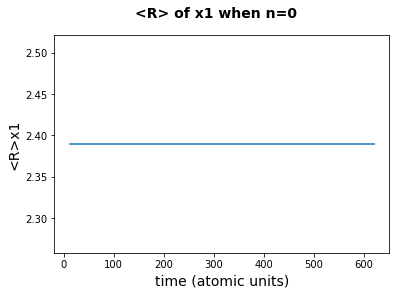

In [22]:
%matplotlib inline
expectationvaluechi1n0 = np.array([2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331, 2.38933331, 2.38933331, 2.38933331, 2.38933331,
       2.38933331])
plt.suptitle('<R> of x1 when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<R>x1", fontsize=14)
plt.plot(times_array1[1:],expectationvaluechi1n0)

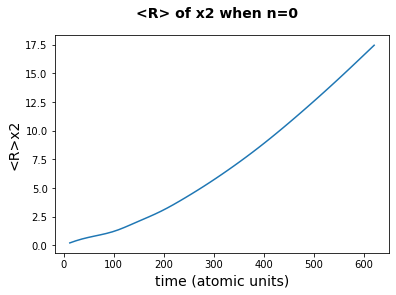

In [23]:
expectationvaluechi2n0 = np.array([0.20126771580648015,
 0.38569044788186524,
 0.5431865967074214,
 0.6748975129648015,
 0.7912705350629607,
 0.9041066062648051,
 1.0256200200821388,
 1.1705313674200846,
 1.3494000963959998,
 1.5599048417596717,
 1.7883371726409687,
 2.0206661634395258,
 2.250319795291082,
 2.480113178090632,
 2.717914478940249,
 2.971617615439763,
 3.245055389881066,
 3.5366595194372237,
 3.841705382344859,
 4.1557803624739424,
 4.476729565179325,
 4.804489431054933,
 5.139878485577452,
 5.483537099870071,
 5.835519601434029,
 6.195442021588772,
 6.562873961896087,
 6.937676176039667,
 7.320091381583568,
 7.710585164297571,
 8.10960938493036,
 8.51745259102726,
 8.934179203415836,
 9.359577111903905,
 9.793124201679863,
 10.234059273886704,
 10.68154946390225,
 11.134834207013476,
 11.593302085708872,
 12.05655018981201,
 12.524460591848028,
 12.99720878873693,
 13.47499345489049,
 13.957918849216,
 14.446064050480883,
 14.93928043617688,
 15.437138528519155,
 15.938943476468536,
 16.44333639804113,
 16.949170023687714,
 17.455906400212005])




plt.suptitle('<R> of x2 when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<R>x2", fontsize=14)
plt.plot(times_array1[1:],expectationvaluechi2n0)

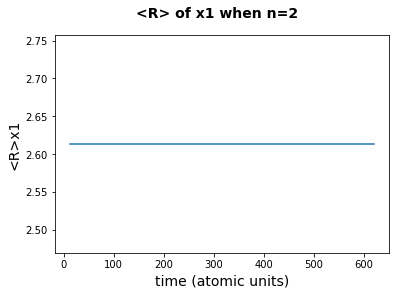

In [24]:
### this is the expectation value when n=2

expectationvaluechi1n2 = np.array([2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253, 2.61308253, 2.61308253, 2.61308253, 2.61308253,
       2.61308253])
plt.suptitle('<R> of x1 when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<R>x1", fontsize=14)
plt.plot(times_array1[1:],expectationvaluechi1n2)

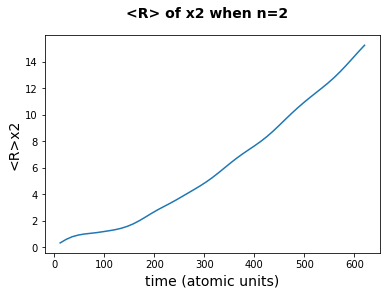

In [25]:
expectationvaluechi2n2 = np.array([0.3121773965608605,
 0.5828898826576886,
 0.7829139603127498,
 0.9078923685818412,
 0.9865221846685623,
 1.038002417411944,
 1.0902117678652454,
 1.1580855247090058,
 1.2289708787366989,
 1.3077912324409329,
 1.414243358519578,
 1.5581749957866684,
 1.7499568103794987,
 1.9900450363224307,
 2.2615697947478264,
 2.542075701860161,
 2.8075087142731623,
 3.051076393451165,
 3.290276098738719,
 3.5431047812957392,
 3.808428358475163,
 4.076966311559156,
 4.345475724749897,
 4.621392524491358,
 4.91867017783448,
 5.246613856790597,
 5.604696028648391,
 5.9810081027900335,
 6.356096278688765,
 6.71333647023519,
 7.046035349321827,
 7.35934496139645,
 7.668899475387778,
 7.99615947138275,
 8.359234144998979,
 8.763696496639195,
 9.199837162405133,
 9.647955268579977,
 10.088494524269574,
 10.509175351711788,
 10.906977469494644,
 11.285361661568471,
 11.650639819506932,
 12.013846926600507,
 12.390875701115533,
 12.799320733405558,
 13.248702082433269,
 13.73313616704497,
 14.238942328919943,
 14.74961024310903,
 15.244557212349088])




plt.suptitle('<R> of x2 when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<R>x2", fontsize=14)
plt.plot(times_array1[1:],expectationvaluechi2n2)

In [26]:
# for 2b the lower is chi 2

In [27]:
shorttime = [0.0,
 6.484922183041403,
 12.969844366082807,
 19.45476654912421,
 25.939688732165614,
 32.42461091520702,
 38.90953309824842,
 45.39445528128982,
 51.87937746433123,
 58.36429964737263,
 64.84922183041404,
 71.33414401345544,
 77.81906619649683,
 84.30398837953824,
 90.78891056257964,
 97.27383274562105,
 103.75875492866246,
 110.24367711170386,
 116.72859929474527,
 123.21352147778667,
 129.69844366082808,
 136.18336584386947,
 142.6682880269109,
 149.15321020995228,
 155.63813239299367,
 162.1230545760351,
 168.60797675907648,
 175.0928989421179,
 181.5778211251593,
 188.0627433082007,
 194.5476654912421,
 201.03258767428352,
 207.5175098573249,
 214.0024320403663,
 220.48735422340772,
 226.9722764064491,
 233.45719858949053,
 239.94212077253192,
 246.42704295557334,
 252.91196513861473,
 259.39688732165615,
 265.8818095046975,
 272.36673168773893,
 278.85165387078035,
 285.3365760538218,
 291.82149823686314,
 298.30642041990455,
 304.791342602946,
 311.27626478598734,
 317.76118696902876,
 324.2461091520702,
 330.7310313351116]

In [28]:
%matplotlib inline

In [29]:
### this is the plot for the shorter timeframe for 2b

In [30]:
blowupchi2 = [0.0,
 9.412396411545565e-05,
 0.00037067946666902163,
 0.0008133481681377175,
 0.0013983270507729184,
 0.002098283558653935,
 0.0028861492653897702,
 0.0037379260615026944,
 0.004634171254303321,
 0.005560284457877596,
 0.006505979752363111,
 0.007464371853677099,
 0.008431009790133004,
 0.009403050588759565,
 0.01037864412398981,
 0.011356523554006404,
 0.012335760622916858,
 0.013315637386696721,
 0.014295591668550323,
 0.015275203398490311,
 0.0162541982679707,
 0.017232452376689467,
 0.01820998700540455,
 0.019186947171237034,
 0.020163562020143355,
 0.02114008976706727,
 0.022116754575924547,
 0.023093686638534505,
 0.024070878541553653,
 0.025048169647196916,
 0.02602526513807657,
 0.02700178820661292,
 0.027977354531821153,
 0.028951650568769915,
 0.02992449424304644,
 0.030895860254733343,
 0.031865862094894504,
 0.03283469634503866,
 0.033802567349121126,
 0.03476961717433891,
 0.03573588388606075,
 0.03670130073769162,
 0.03766573358572689,
 0.03862903959423958,
 0.03959112287267308,
 0.040551965220262165,
 0.04151162158024768,
 0.04247018520369428,
 0.04342774015958761,
 0.04438432319904728,
 0.04533991134651727,
 0.046294438814212246]

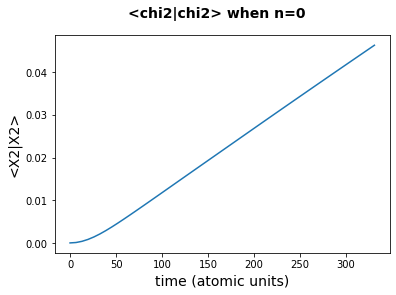

In [31]:
%matplotlib inline
plt.suptitle('<chi2|chi2> when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(shorttime,blowupchi2)

35

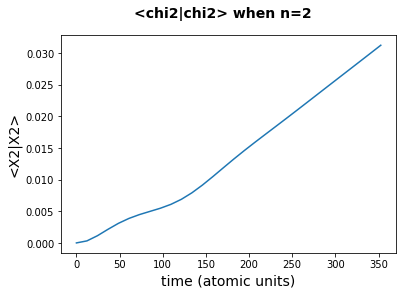

In [85]:
%matplotlib inline
plt.suptitle('<chi2|chi2> when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array[:30],normarrayn2chi2[:30])

In [32]:
#starts being linear at about 40 atomic second for n = 0 and 200 seconds for n=2


In [33]:
norm_2_array

[0.0,
 0.00032660395940631304,
 0.001240213312948435,
 0.002582011164090625,
 0.00418151281890311,
 0.005913059095773776,
 0.007705391317111787,
 0.009524835798023434,
 0.011356523554006404,
 0.013193138393816195,
 0.015030350136880144,
 0.016865695547766513,
 0.01869852596333188,
 0.020529756685772393,
 0.022360960239495742,
 0.024193039414707407,
 0.026025265138076237,
 0.027855472852652663,
 0.029681423530166007,
 0.03150225977365928,
 0.03331874124105105,
 0.035132060499908246,
 0.036942507111135,
 0.03874936804496387,
 0.040551965220260944,
 0.042350421296710294,
 0.0441452688576377,
 0.0459366202345447,
 0.047724090010339504,
 0.049507452787880823,
 0.05128698074032212,
 0.053063017538180435,
 0.05483554188513251,
 0.05660439748865154,
 0.058369755104527354,
 0.06013205212786776,
 0.06189156437721255,
 0.06364834696086263,
 0.06540261604049091,
 0.06715490569550253,
 0.06890574873487842,
 0.07065544193286533,
 0.07240428194680637,
 0.07415283533665151,
 0.0759017571791123,
 0.077

In [34]:
blowupchi2n2 = [0.0,
 9.349465160413128e-05,
 0.00036099154089253016,
 0.0007672771055684535,
 0.0012644620207296065,
 0.001803292806777268,
 0.0023421540306193256,
 0.0028516242811397197,
 0.003314844181867671,
 0.003725425605387578,
 0.004084757012796203,
 0.004399812598535613,
 0.004681693699071676,
 0.004944598261062749,
 0.005204810265046822,
 0.005479465973953435,
 0.0057850877861674865,
 0.006136050670177862,
 0.006543218087278091,
 0.0070129665436863275,
 0.007546743973124381,
 0.008141210587450542,
 0.008788916983307415,
 0.009479399104234898,
 0.010200521177160193,
 0.010939878151403515,
 0.011686076688877334,
 0.012429744221544414,
 0.01316416353604477,
 0.013885489435061071,
 0.01459256695635458,
 0.015286428886970738,
 0.015969594478230098,
 0.016645312497830855,
 0.017316884382298614,
 0.017987167735338372,
 0.018658305079938264,
 0.019331662825679774,
 0.020007918694416094,
 0.02068721635224391,
 0.021369317818991762,
 0.022053719008516715,
 0.02273973357453618,
 0.02342657540763604,
 0.024113468612311006,
 0.024799787599654843,
 0.025485194782935205,
 0.026169721064002727,
 0.026853741171142587,
 0.027537833188555072,
 0.028222563261516398,
 0.02890827630102466]

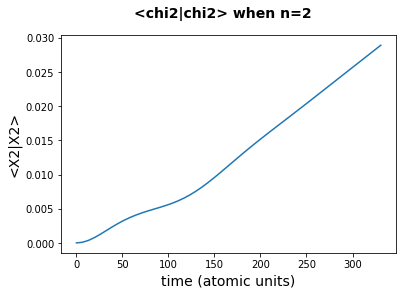

In [35]:
%matplotlib inline
plt.suptitle('<chi2|chi2> when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(shorttime,blowupchi2n2)

In [36]:
# stops being linerar at about 150

In [37]:
### it was not asked but I replotted the population so that I could cut off the non linear portion. 
#### I plotted the linear portion because I wanted to verify it was linear then calculated the slope that way



### this is for number 3


In [38]:
chi2n1 = [0.0,
 0.00032292323516180943,
 0.0011883697228841639,
 0.002366019925384988,
 0.0036443566291147755,
 0.00490203203519235,
 0.0060888120954313285,
 0.00718434077499186,
 0.008177819880097248,
 0.009066549035009142,
 0.009858638070558867,
 0.010572141620140751,
 0.011230257557041545,
 0.011855238964359471,
 0.01246387296216811,
 0.013066261607614371,
 0.013667731818852502,
 0.014271744195353375,
 0.014881158362206603,
 0.015497130039387352,
 0.016117814029974253,
 0.016739593899323668,
 0.017360464823880983,
 0.01798193511215751,
 0.018607016229964413,
 0.01923667935387996,
 0.0198692334014845,
 0.020503163040891614,
 0.02113926459397053,
 0.0217791782957375,
 0.022422802022385113,
 0.023068531482905774,
 0.023715726023980976,
 0.02436542451912649,
 0.02501832177982166,
 0.025673398148198245,
 0.026329348546859088,
 0.02698632827829084,
 0.027645160827173942,
 0.028305462363102385,
 0.02896585145128805,
 0.02962579826544831,
 0.0302859433816689,
 0.030946413057564515,
 0.031606063096332515,
 0.032263918820841564,
 0.03292030185103134,
 0.033575726887437374,
 0.034229511510767585,
 0.034880500731729325,
 0.0355286326019969,
 0.03617463681503985]

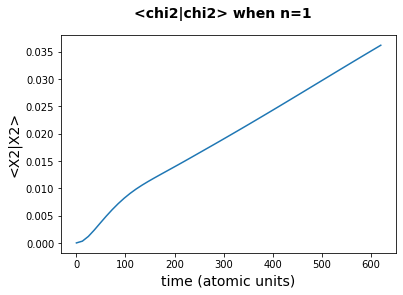

In [39]:
%matplotlib inline
plt.suptitle('<chi2|chi2> when n=1', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,chi2n1)

In [40]:
# start being linear at 125

In [41]:
# time in femtoseconds
femto = np.linspace(0,15,52)

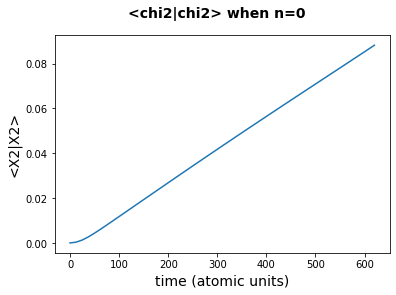

In [42]:
plt.suptitle('<chi2|chi2> when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,normarrayn0chi2)

#### <chi2|chi2> when n=0

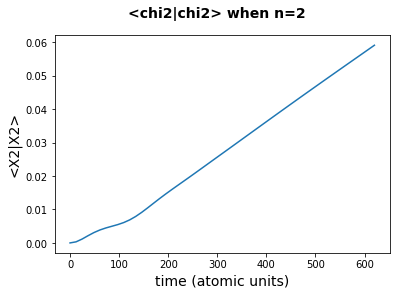

In [43]:
plt.suptitle('<chi2|chi2> when n=2', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,normarrayn2chi2)

In [44]:
linerarn0 = np.array([0.047724090010339504,
 0.049507452787880823,
 0.05128698074032212,
 0.053063017538180435,
 0.05483554188513251,
 0.05660439748865154,
 0.058369755104527354,
 0.06013205212786776,
 0.06189156437721255,
 0.06364834696086263,
 0.06540261604049091,
 0.06715490569550253,
 0.06890574873487842,
 0.07065544193286533,
 0.07240428194680637,
 0.07415283533665151,
 0.0759017571791123,
 0.07765145596968515,
 0.0794021532321908,
 0.08115418701831778,
 0.08290798375722952,
 0.0846637023914043,
 0.08642112351426179,
 0.08817992984017964])

In [45]:
lineartime = np.array([340.4584146096737,
 352.6176437028763,
 364.7768727960789,
 376.9361018892816,
 389.0953309824842,
 401.2545600756868,
 413.4137891688895,
 425.5730182620921,
 437.7322473552947,
 449.8914764484974,
 462.0507055417,
 474.2099346349026,
 486.36916372810526,
 498.5283928213079,
 510.6876219145105,
 522.8468510077131,
 535.0060801009158,
 547.1653091941184,
 559.324538287321,
 571.4837673805237,
 583.6429964737263,
 595.8022255669289,
 607.9614546601316,
 620.1206837533342])

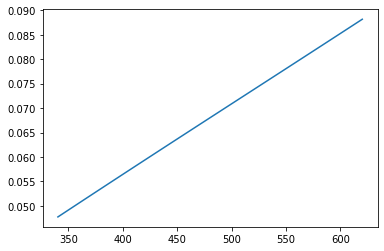

In [46]:
# this is a plot of the linear portion of n = 0

plt.plot(lineartime,linerarn0)

In [47]:
np.polyfit(lineartime, linerarn0, 1)

array([ 0.00014444, -0.00137293])

In [48]:
slopen0, intercept = np.polyfit(lineartime, linerarn0,1)

In [49]:
# this is the rate when n = 0
slopen0

0.00014444165098881026

In [50]:
# this is the lifetime in atomic units 
lifetime0au = 1/slopen0
lifetime0au

6923.210813184827

In [51]:
linearn1 =  np.array([0.029938613428050487,
 0.031227772224918682,
 0.032516005115233226,
 0.033803218044183625,
 0.03509059572680684,
 0.036377551400953556,
 0.03766189855356439,
 0.03894290346102436,
 0.04022199922774072,
 0.04149985214207452,
 0.04277468631034498,
 0.044044776551459885,
 0.04531102819953159,
 0.04657535203769814,
 0.04783756703899822,
 0.049096004109941305,
 0.05035070915122264,
 0.051603786346385294,
 0.05285634435971698,
 0.054107275302633595,
 0.05535589106002203,
 0.05660381837399675,
 0.0578528688090123,
 0.05910253970090373])

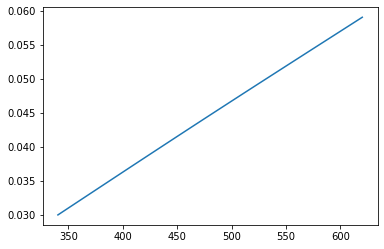

In [52]:
plt.plot(lineartime,linearn1)

In [53]:
# this is the rate when n=1
slopen1, intercept = np.polyfit(lineartime, linearn1,1)
slopen1

0.00010426653588917798

In [54]:
# this is the lifetime in atomic units 
raten1au = 1/slopen1
raten1au

9590.804868235695

In [55]:
linear2 = np.array([ 0.02113926459397053,
 0.0217791782957375,
 0.022422802022385113,
 0.023068531482905774,
 0.023715726023980976,
 0.02436542451912649,
 0.02501832177982166,
 0.025673398148198245,
 0.026329348546859088,
 0.02698632827829084,
 0.027645160827173942,
 0.028305462363102385,
 0.02896585145128805,
 0.02962579826544831,
 0.0302859433816689,
 0.030946413057564515,
 0.031606063096332515,
 0.032263918820841564,
 0.03292030185103134,
 0.033575726887437374,
 0.034229511510767585,
 0.034880500731729325,
 0.0355286326019969,
 0.03617463681503985])

#this is the rate when n=2 
slopen2, intercept = np.polyfit(lineartime, linear2,1)
slopen2

5.3944132000092616e-05

In [56]:
# this is the lifetime in atomic units 
raten2au = 1/slopen2
raten2au

18537.697482986343

In [57]:
femto = np.array([8.23529412,  8.52941176,
        8.82352941,  9.11764706,  9.41176471,  9.70588235, 10.        ,
       10.29411765, 10.58823529, 10.88235294, 11.17647059, 11.47058824,
       11.76470588, 12.05882353, 12.35294118, 12.64705882, 12.94117647,
       13.23529412, 13.52941176, 13.82352941, 14.11764706, 14.41176471,
       14.70588235, 15.])

In [58]:
# This calculates the slope in femto seconds and which then gives the lifetime in atomic seconds 
slopefs0, intercept = np.polyfit(femto, linerarn0,1)
slopefs0

0.005971417024958098

In [59]:
# lifetime in fs when n=0
rate0fs = 1/slopefs0
rate0fs

167.46443864503286

In [60]:
slope1fs, intercept = np.polyfit(femto, linearn1 ,1)
slope1fs 

0.0043105223685824595

In [61]:
rate1fs = 1/slope1fs
rate1fs

231.99044442700708

In [62]:
slope2fs, intercept = np.polyfit(femto, linear2,1)
slope2fs

0.0022301248013751624

In [63]:
rate2fs = 1/slope2fs
rate2fs

448.4053983810098

In [64]:
###### this is for number 4

In [65]:
# This is the eigen values that came out of the template. When I change n to 0 1 2 I did not see any changes 


diabaticn0 = np.array([-4.76183421e-03, -3.18314073e-03, -1.92129806e-03, -9.76306191e-04,
       -3.48165128e-04, -3.68728556e-05,  1.39478517e-05,  5.12216704e-05,
        1.07212045e-04,  1.79841123e-04,  2.67925459e-04,  3.70659813e-04,
        4.87447079e-04,  6.17821301e-04,  7.61405995e-04,  9.17889113e-04,
        1.08700691e-03,  1.26853298e-03,  1.46227049e-03,  1.66804652e-03,
        1.88570774e-03,  2.11511713e-03,  2.35615139e-03,  2.60869889e-03,
        2.87265798e-03,  3.14793563e-03,  3.43444631e-03,  3.73211102e-03,
        4.04085653e-03,  4.36061470e-03,  4.69132191e-03,  5.03291854e-03,
        5.38534860e-03,  5.74855933e-03,  6.12250086e-03,  6.50712601e-03,
        6.90238997e-03,  7.30825011e-03,  7.72466581e-03,  8.15159827e-03,
        8.58901037e-03,  9.03686654e-03,  9.49513263e-03,  9.96377581e-03,
        1.04427645e-02,  1.09320682e-02,  1.14316575e-02,  1.19415041e-02,
        1.24615805e-02,  1.29918600e-02,  1.35323168e-02,  1.40829260e-02,
        1.46436631e-02,  1.52145047e-02,  1.57954278e-02,  1.63864099e-02,
        1.69874293e-02,  1.75984647e-02,  1.82194955e-02,  1.88505015e-02,
        1.94914628e-02,  2.01423602e-02,  2.08031749e-02,  2.14738884e-02,
        2.21544827e-02,  2.28449400e-02,  2.35452432e-02,  2.42553751e-02,
        2.49753193e-02,  2.57050594e-02,  2.64445793e-02,  2.71938635e-02,
        2.79528965e-02,  2.87216631e-02,  2.95001485e-02,  3.02883382e-02,
        3.10862176e-02,  3.18937728e-02,  3.27109898e-02,  3.35378550e-02,
        3.43743549e-02,  3.52204764e-02,  3.60762063e-02,  3.69415318e-02,
        3.78164404e-02,  3.87009195e-02,  3.95949569e-02,  4.04985406e-02,
        4.14116586e-02,  4.23342991e-02,  4.32664507e-02,  4.42081018e-02,
        4.51592411e-02,  4.61198576e-02,  4.70899404e-02,  4.80694784e-02,
        4.90584612e-02,  5.00568780e-02,  5.10647186e-02,  5.20819725e-02,
        5.31086296e-02,  5.41446799e-02,  5.45561230e-02,  5.51901135e-02,
        5.62449205e-02,  5.73090913e-02,  5.83826162e-02,  5.94654859e-02,
        6.05576909e-02,  6.16592219e-02,  6.27700699e-02,  6.31899249e-02,
        6.38902258e-02,  6.50196806e-02,  6.61584255e-02,  6.73064516e-02,
        6.84637504e-02,  6.96303133e-02,  7.08061317e-02,  7.11858012e-02,
        7.19911973e-02,  7.31855018e-02,  7.43890368e-02,  7.56017943e-02,
        7.68237662e-02,  7.80549445e-02,  7.85437521e-02,  7.92953213e-02,
        8.05448888e-02,  8.18036391e-02,  8.30715647e-02,  8.43486578e-02,
        8.52637774e-02,  8.56349111e-02,  8.69303168e-02,  8.82348678e-02,
        8.95485565e-02,  9.08713759e-02,  9.13458772e-02,  9.22033186e-02,
        9.35443775e-02,  9.48945455e-02,  9.62538157e-02,  9.67900515e-02,
        9.76221811e-02,  9.89996346e-02,  1.00386169e-01,  1.01596300e-01,
        1.01781779e-01,  1.03186455e-01,  1.04600196e-01,  1.05764624e-01,
        1.06022989e-01,  1.07454831e-01,  1.08895713e-01,  1.09295021e-01,
        1.10345632e-01,  1.11804579e-01,  1.12187493e-01,  1.13272547e-01,
        1.14442040e-01,  1.14749532e-01,  1.16058661e-01,  1.16235531e-01,
        1.17037357e-01,  1.17379601e-01,  1.17399293e-01,  1.17436825e-01,
        1.17490804e-01,  1.17560194e-01,  1.17644288e-01,  1.17730529e-01,
        1.17742563e-01,  1.17854608e-01,  1.17980087e-01,  1.18118716e-01,
        1.18270253e-01,  1.18434485e-01,  1.18611225e-01,  1.18800304e-01,
        1.19001572e-01,  1.19214890e-01,  1.19234512e-01,  1.19440135e-01,
        1.19677189e-01,  1.19925947e-01,  1.20186309e-01,  1.20458182e-01,
        1.20741482e-01,  1.20747573e-01,  1.21036125e-01,  1.21342038e-01,
        1.21659146e-01,  1.21987384e-01,  1.22269467e-01,  1.22326686e-01,
        1.22676992e-01,  1.23038243e-01,  1.23410384e-01,  1.23793363e-01,
        1.23800431e-01])

In [66]:
# Fermi Golden Rule matrix element for n=0
V12n0 = -0.00016017318530886163

In [67]:
# Fermi Golden Rule matrix element for n = 1
V12n1 = 0.0001511548634870923

In [68]:
# Fermi Golden Rule matrix element n = 2
V12n2 = 6.323356559087739e-05

In [69]:
# Fermi Golden Rule matrix element n = 3
V12n3 = -0.00011872703609228501

In [70]:
# this gives you the density of states 
DOS = []
for i in np.arange(1,198): 
    DOS.append(2/(diabaticn0[i+1]-diabaticn0[i-1]))

In [71]:
DOS

[704.0924298745501,
 906.2754659016149,
 1271.3483770613734,
 2128.942975127046,
 5523.138114676092,
 22702.886215654307,
 21444.457183762508,
 15549.747410447306,
 12444.51194347723,
 10481.153601882497,
 9110.71993728909,
 8091.8755433289825,
 7300.364701399243,
 6665.160073883569,
 6142.488880905018,
 5703.792902785892,
 5329.587273030864,
 5006.088154108619,
 4723.250021107025,
 4473.566267306186,
 4251.30618725537,
 4052.01359142607,
 3872.1674393350936,
 3708.9460929535335,
 3560.0597114575157,
 3423.6293315950866,
 3298.0974496109234,
 3182.161160933854,
 3074.721670813597,
 2974.845421082229,
 2881.7335540798863,
 2794.698161349916,
 2713.143686217552,
 2636.55134443817,
 2564.4671458484677,
 2496.4921165147825,
 2432.2738218843933,
 2371.499808572538,
 2313.89204323794,
 2259.2021738224016,
 2207.207667539258,
 2157.7084885557356,
 2110.524205987289,
 2065.491808729386,
 2022.463502118026,
 1981.304607850782,
 1941.8927434381012,
 1904.1164999406406,
 1867.8735371164687,
 1833

In [72]:
# I made a chart because I found it easier to look at everything that way
Table().with_columns("n_state",range(0,number_of_eigenvectors-3),"E(n)",diabaticn0[:-4],"density",DOS).show()

n_state,E(n),density
0,-0.00476183,704.092
1,-0.00318314,906.275
2,-0.0019213,1271.35
3,-0.000976306,2128.94
4,-0.000348165,5523.14
5,-3.68729e-05,22702.9
6,1.39479e-05,21444.5
7,5.12217e-05,15549.7
8,0.000107212,12444.5
9,0.000179841,10481.2


In [73]:
# the rate using Fermi Golden Rule when n = 0
wn0  = (np.pi*2)* (V12n0)**2 * 927.474
wn0

0.00014950690009607364

In [74]:
# the rate using Fermi Golden Rule when n = 1
wn1 = (np.pi*2)* V12n1**2 * 834.084
wn1

0.00011973852651203257

In [75]:
# the rate using Fermi Golden Rule when n = 2
wn2 = (np.pi*2)* V12n2**2 * 1913.08
wn2

4.806271971617004e-05

In [76]:
# problem 5

In [77]:
p5norm = np.array([0.0,
 0.014445683742969395,
 0.05405203448274798,
 0.10972707063596898,
 0.17133009503194208,
 0.23079183907216883,
 0.2828587384406479,
 0.3245194219475739,
 0.3543973175088201,
 0.3726017038402415,
 0.38090505037087563,
 0.3828479349969637,
 0.38331314373183467,
 0.38728021119273826,
 0.39798670183316753,
 0.4154354404011439,
 0.4364813327248358,
 0.45692907239344704,
 0.47438989223644135,
 0.489598304952254,
 0.5049948891723753,
 0.5220225666944189,
 0.5399486958249973,
 0.5572511785019263,
 0.573598709921278,
 0.5899642168508923,
 0.6070595014123705,
 0.6244368592772951,
 0.6413623864495457,
 0.6579289796926395,
 0.674751032136725,
 0.691911913769468,
 0.7088799892693799,
 0.7253941008318008,
 0.7417877727527107,
 0.7582882413744486,
 0.7745447506051454,
 0.7901492778240162,
 0.8051921993445965,
 0.8199070779509245,
 0.8340731301659277,
 0.8472229303429566,
 0.859260567336102,
 0.8704015507410029,
 0.8805729126892115,
 0.8893554215933092,
 0.8965684628234489,
 0.9024635660516488,
 0.9072040248179304,
 0.9105764885492955,
 0.9124556292792556,
 0.913197221042277])

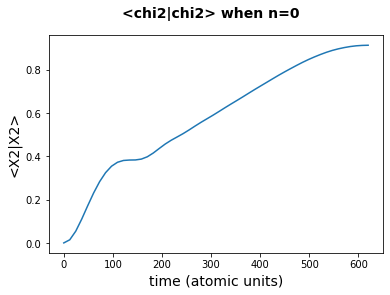

In [78]:
#### <chi1|chi1> when n=0
plt.suptitle('<chi2|chi2> when n=0', fontsize=14, fontweight='bold')
plt.xlabel("time (atomic units)", fontsize=14)
plt.ylabel("<X2|X2>", fontsize=14)
plt.plot(times_array,p5norm)

In [79]:
p5V12 = -0.0010678212353924105

In [80]:
(np.pi*2)* (p5V12)**2 * 927.474
# the population is less linear and the rate becomes less accurate 
# the linear region is now shorter (between 200-500 atomic seconds)

0.006644751115381047

In [81]:
# if the distance is too small V12 is 0